In [2]:
# %matplotlib nbagg
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader

import torchvision.transforms as tf
from torchvision.datasets import MNIST

import hydra
from omegaconf import DictConfig
import matplotlib.pyplot as plt
# import matplotlib.animation as animation

from fastprogress import master_bar, progress_bar

from lienp.models import GridConvCNP, GridPointCNP
from lienp.models.liecnp import GridLieCNP
from lienp.utils import Metric
from lienp.visualize import plot_and_save_image2
from lienp.liegroups import T, SO2, RxSO2, SE2
from lienp.datasets.clockdigit import ClockDigit

from lienp.liegroups import *
from lienp.models import LieCNP
from lienp.modules import LieConv
from lienp.modules.group_farthersubsample import GroupFartherSubsample
from torchvision.transforms import Pad, ToTensor, ToPILImage

In [3]:
transforms = tf.Compose([
            tf.Pad(16),
            tf.RandomAffine(degrees=90, scale=(0.6, 0.9)),
            tf.ToTensor()
        ])
testset = ClockDigit("~/data/clockdigits", download=True, transform=transforms)

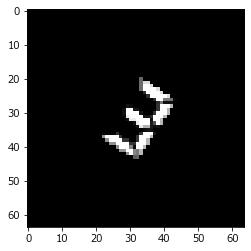

In [4]:
plt.gray()
f = testset[3][0].reshape(1, 4096, 1)
coords = torch.linspace(-32, 32, 64)
coords = torch.stack(torch.meshgrid([coords, coords]), -1).reshape(1, -1, 2)
mask = torch.ones(1, 4096).bool()
plt.imshow(f.reshape(64, 64))

In [4]:
r = 1
group = T(2)
nbhd=1
fill = 81/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]

r=1.0029, fill=0.0198, 69.0000/4096=0.0168
r=1.0029, fill=0.0198, 69.0000/4096=0.0168
r=0.1069, fill=0.0732, 108.0000/4096=0.0264
r=0.5593, fill=0.0732, 57.0000/4096=0.0139


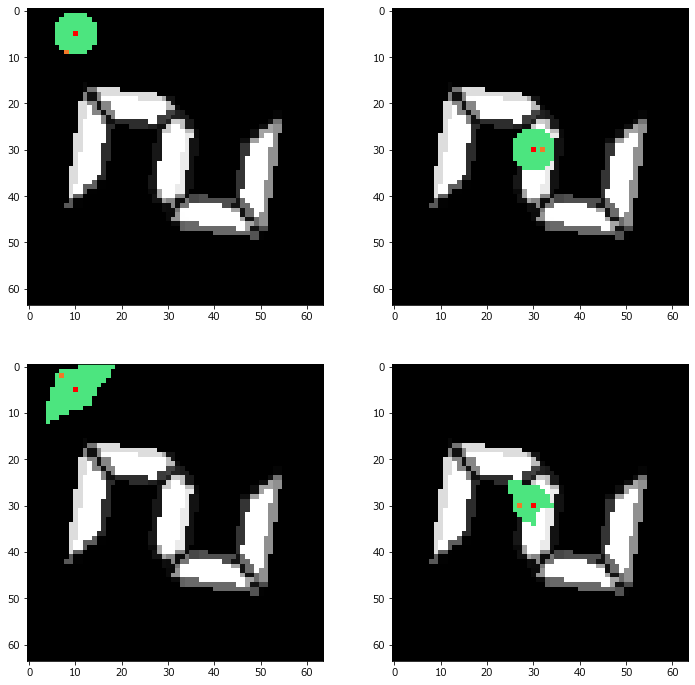

In [5]:
plt.figure(figsize=(12, 12))
# idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
r = 1
group = T(2)
nbhd=1
fill = 81/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[10 * 30 + 30]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(221)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 1
group = T(2)
nbhd=1
fill = 81/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[64 * 30 + 30]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(222)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 0.06
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[10 * 30 + 30]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(223)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 0.5
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[64 * 30 + 30]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(224)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()

r=0.1142, fill=0.0732, 242.0000/4096=0.0591
r=0.1291, fill=0.0732, 181.0000/4096=0.0442
r=0.1144, fill=0.0732, 241.0000/4096=0.0588
r=0.1566, fill=0.0732, 68.0000/4096=0.0166


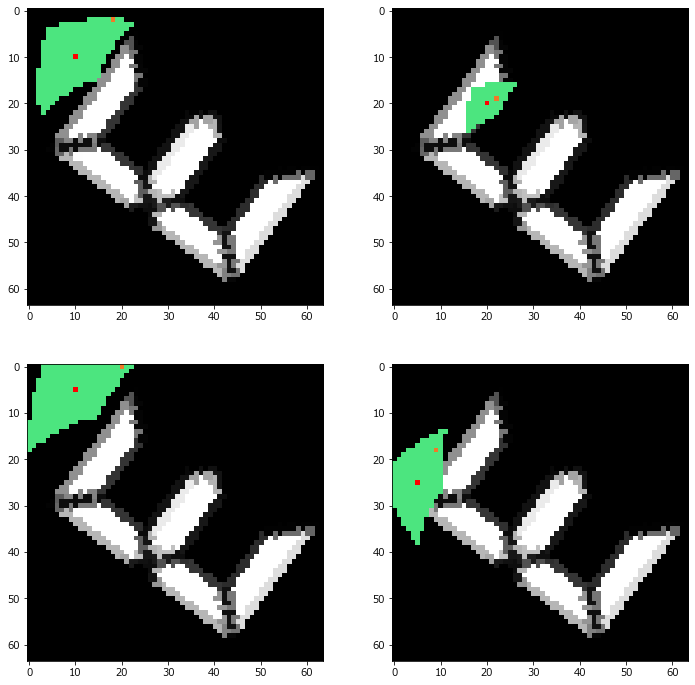

In [93]:
plt.figure(figsize=(12, 12))
r = 0.1
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[10 * 30 + 30]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(223)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 0.1
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[64 * 25 + 5]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(224)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 0.1
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[64 * 10 + 10]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(221)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)
#         plt.show()
r = 0.1
group = SO2()
nbhd=1
fill = 300/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
for n in range(10):
#     idx = GroupFartherSubsample(1/4096, group=group)(lifted_inputs, withquery=True)[3]
    idx = torch.as_tensor([[64 * 20 + 20]])
    ab_at_query = lifted_inputs[0][B, idx]
    mask_at_query = lifted_inputs[2][B, idx]
    dist_matrix = group.distance(ab_at_query)
    dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))
    within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
    r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
    nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)[1]
    if n % 10 ==0:
        if torch.sum(within_ball) < nbhd:
            print("out")
        print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
        img = f.reshape(64, 64, 1).repeat(1, 1, 3)
        plt.subplot(222)
        plt.imshow(img)
        img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
        tmp_idx = nbhd_idx[0].reshape(-1)
        img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
        img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
        plt.imshow(img)

In [6]:
torch.as_tensor(2.)

tensor(2.)

r=0.1038, fill=0.0122, 2428.0000/4096=0.5928


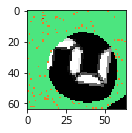

In [7]:
# r = 1.0
group = RxSO2()
nbhd=100
fill = 50/4096
lifted_inputs = group.lift((coords, f, mask), 1)
B = torch.arange(1).long()[:, None]
idx = torch.as_tensor([[10 * 30 + 30]])

ab_at_query = lifted_inputs[0][B, idx]
mask_at_query = lifted_inputs[2][B, idx]

dist_matrix = group.distance(ab_at_query)
dist_matrix = torch.where(lifted_inputs[2][:, None, :], dist_matrix, 1e8 * torch.ones_like(dist_matrix))

within_ball = (dist_matrix < r) & lifted_inputs[2][:, None, :] & mask_at_query[:, :, None]
r += fill - within_ball.float().sum(-1).sum() / mask_at_query[:, :, None].sum() /  lifted_inputs[2].sum(-1).float().mean()
valid_within_ball, nbhd_idx = torch.topk(within_ball + torch.zeros_like(dist_matrix).uniform_(0, 1), nbhd, dim=-1, largest=True, sorted=False)
valid_within_ball = valid_within_ball > 1

# nbhd_idx = nbhd_idx[valid_within_ball]

if torch.sum(within_ball) < nbhd:
    print("out")
print("r={:.4f}, fill={:.4f}, {:.4f}/4096={:.4f}".format(r,fill, torch.sum(within_ball[0, 0]), torch.sum(within_ball[0, 0]).float().div(4096.)))
img = f.reshape(64, 64, 1).repeat(1, 1, 3)
plt.subplot(223)
plt.imshow(img)
img[within_ball[0, 0].reshape(64, 64)] = torch.tensor([0.3, 0.9, 0.5])
tmp_idx = nbhd_idx.reshape(-1)
img[tmp_idx//64, tmp_idx%64] = torch.tensor([242/255, 120/255, 40/255])
img[idx[0]//64, idx[0]%64] = torch.tensor([1.0, 0, 0])
plt.imshow(img)
#         plt.show()


In [8]:
mask[B, nbhd_idx] & valid_within_ball.bool()

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True]]])

In [9]:
nbhd_idx.shape

torch.Size([1, 1, 100])

In [11]:
from lienp.modules.lieconv import LieConv, SeparableLieConv

In [94]:
g = RxSO2()
# lc = LieConv(1, 3, group=g, sampling_fraction=1., fill=81/4096, num_nbhd=81, use_bn=True, mean=False)
slc = SeparableLieConv(1, 3, group=g, sample=1, num_nbhd=100, fill=81/4096, r=2, mean=True, use_bn=True)
slc.depthwise.mean = False
# slc.depthwise.cache=True

lifted_input = g.lift((coords,f,mask), 1)

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.0569)


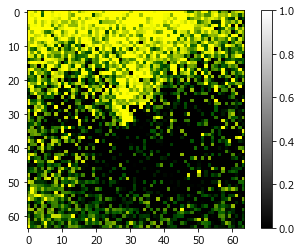

12345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1888)


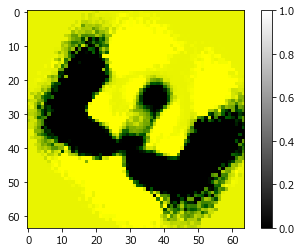

678910


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1288)


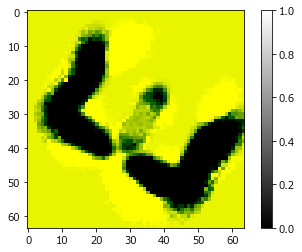

1112131415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1139)


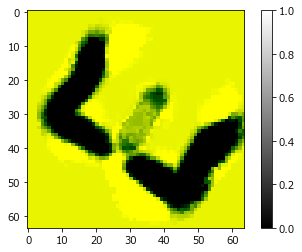

1617181920


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1094)


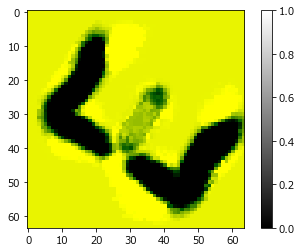

2122232425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1080)


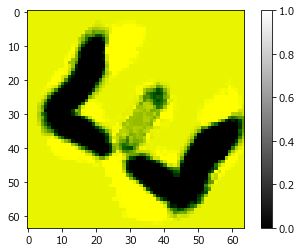

2627282930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1075)


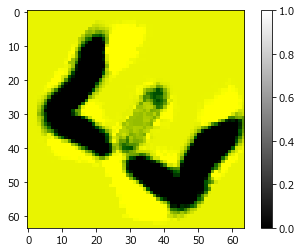

3132333435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1074)


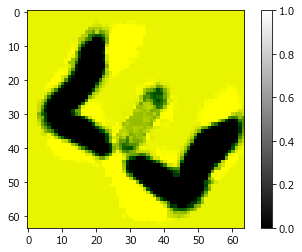

3637383940


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


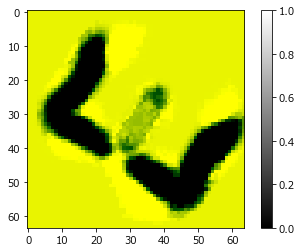

4142434445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


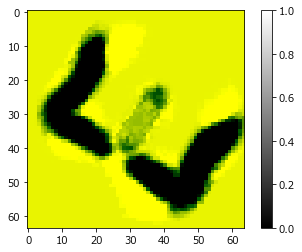

4647484950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


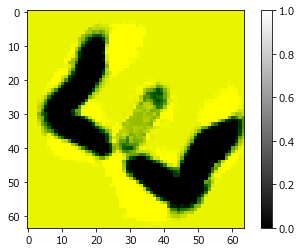

5152535455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


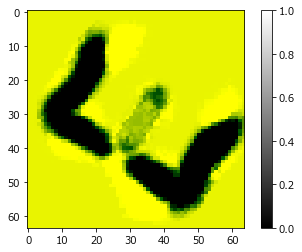

5657585960


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


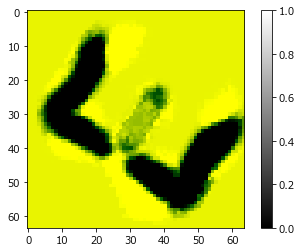

6162636465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


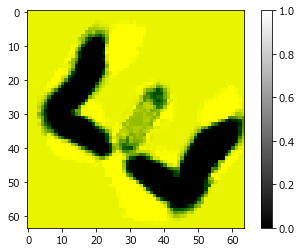

6667686970


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1073)


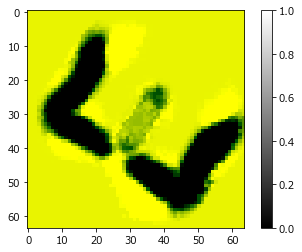

7172737475


KeyboardInterrupt: 

In [95]:
for i in range(200):
#     lc(lifted_input)
    slc(lifted_input)
    print(f"{i}", end="")
    if i % 5 == 0:
        print()
#         plt.imshow(lc(lifted_input)[1].reshape(64, 64, 3).detach())
#         print(lc.r)
#         plt.show()
        plt.imshow(slc(lifted_input)[1].reshape(64, 64, 3).detach())
        print(slc.depthwise.r)
        plt.colorbar()
        plt.show()

In [5]:
def erase_img(img):
    img_c, img_h, img_w = img.shape[1:]
    area = img_h * img_w
    scale=(0.02, 0.33)
    ratio=(0.3, 3.3)
    value = 0
    import random, math

    for _ in range(10):
        erase_area = random.uniform(scale[0], scale[1]) * area
        aspect_ratio = random.uniform(ratio[0], ratio[1])
        erase_area = 0.1 * area
        
        h = int(round(math.sqrt(erase_area * aspect_ratio)))
        w = int(round(math.sqrt(erase_area / aspect_ratio)))

        if h < img_h and w < img_w:
            i = random.randint(0, img_h - h)
            j = random.randint(0, img_w - w)
            v = value
            return i, j, h, w, v
    

In [6]:
from lienp.models.liecnp import GridLieCNP
import torch
from torchvision.transforms import functional as F
from torchvision import transforms as tf
compose = tf.Compose([
    tf.ToPILImage(),
    tf.Lambda(lambda x: tf.functional.affine(x, 0, (0, 0), 0.8, 0)),
    tf.ToTensor()
])

test_tf = tf.Compose([
    tf.Pad(16),
    tf.Lambda(lambda x: tf.functional.affine(x, 5, (0, 0), 2.0, 0)),
    tf.ToTensor()
])
testset = ClockDigit("~/data/clockdigits", download=True, transform=test_tf)
img = testset[3][0]
erasemask = erase_img(img.reshape(1, 1, 64, 64))

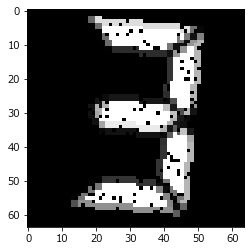

In [7]:
plt.imshow(img.reshape(64, 64))
mask = torch.empty(1, 1, 64, 64).bernoulli_(0.9)#.repeat(1, 3, 1, 1)
plt.imshow(img.reshape(64, 64) * mask.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


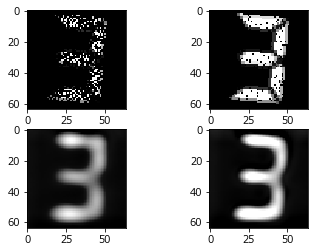

In [8]:
erasemask = erase_img(img.reshape(1, 1, 64, 64))
ctx_mask = F.erase(torch.ones(1, 64, 64), *erasemask).float()

ctx_mask = torch.empty(1, 64, 64).bernoulli_(0.9)#.repeat(1, 3, 1, 1)

ctx_signal = (ctx_mask * img).permute(1, 2, 0).reshape(1, -1, 1)
ctx_coords = torch.linspace(-32, 32, 64).float()
ctx_coords = torch.stack(torch.meshgrid([ctx_coords, ctx_coords]), -1).reshape(1, -1, 2)
ctx_density = ctx_mask.reshape(1, -1, 1)
ctx_mask = torch.ones(1, 4096).bool()

m = GridLieCNP(channel=1, group=T(2))
m.load_state_dict(torch.load("model_weight-T2.pth"))
with torch.no_grad():
    a = m.predict(img.unsqueeze(0), ctx_coords, ctx_density, ctx_signal, ctx_mask)
    b = m(img.unsqueeze(0))
plt.subplot(221)
plt.imshow(img.reshape(64, 64) * b[2].reshape(64, 64))
plt.subplot(222)
plt.imshow(img.reshape(64, 64) * a[2].reshape(64, 64))
plt.subplot(223)
plt.imshow(b[0].reshape(64, 64, 1).repeat(1, 1, 3))
plt.subplot(224)
plt.imshow(a[0].reshape(64, 64, 1).repeat(1, 1, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


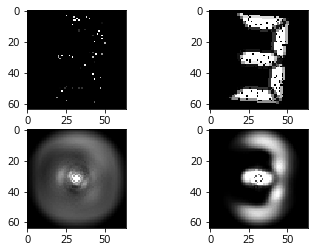

In [9]:
m = GridLieCNP(channel=1, group=RxSO2())
m.load_state_dict(torch.load("model_weight-RxSO2.pth"))
with torch.no_grad():
    a = m.predict(img.unsqueeze(0), ctx_coords, ctx_density, ctx_signal, ctx_mask)
    b = m(img.unsqueeze(0))
plt.subplot(221)
plt.imshow(img.reshape(64, 64) * b[2].reshape(64, 64))
plt.subplot(222)
plt.imshow(img.reshape(64, 64) * a[2].reshape(64, 64))
plt.subplot(223)
plt.imshow(b[0].reshape(64, 64, 1).repeat(1, 1, 3))
plt.subplot(224)
plt.imshow(a[0].reshape(64, 64, 1).repeat(1, 1, 3))

In [62]:
observed = torch.zeros(64, 64, 3)

In [63]:
observed[:, :, 2] = 1
observed[a[2].squeeze() == 1] = img.squeeze()[a[2].squeeze() == 1].unsqueeze(-1)

In [65]:
observed[a[2].squeeze() == 1].shape

torch.Size([3701, 3])

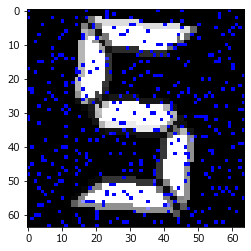

In [88]:
plt.imshow(observed)

In [84]:
b[2].squeeze() == 1

tensor([[ True, False,  True,  ..., False, False, False],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])

In [10]:
from torchvision.utils import make_grid, save_image
from lienp.models.liecnp import GridLieCNP
import torch
from torchvision.transforms import functional as F
from torchvision import transforms as tf

test_tf = tf.Compose([
    tf.Pad(16),
    tf.Lambda(lambda x: tf.functional.affine(x, 5, (0, 0), 2.0, 0)),
    tf.ToTensor()
])
testset = ClockDigit("~/data/clockdigits", download=True, transform=test_tf)

In [134]:
masks = []
for i in range(4):
    ctx_mask25 = torch.empty(1, 64, 64).bernoulli_(0.25)
    ctx_mask75 = torch.empty(1, 64, 64).bernoulli_(0.75)
    masks += [ctx_mask25, ctx_mask75]

imgs = []
idx = torch.randperm(10)
for i in range(4):
    test_tf = tf.Compose([
        tf.Pad(16),
        tf.Lambda(lambda x: tf.functional.affine(x, 5, (0, 0), 2.0 - i * 0.5 + 0.1, 0)),
        tf.RandomAffine(degrees=90),
        tf.ToTensor()
    ])
    testset = ClockDigit("~/data/clockdigits", download=True, transform=test_tf)
    img = testset[idx[i]][0]
    imgs += [img, img]
# ctx_signal = (ctx_mask * img).permute(1, 2, 0).reshape(1, -1, 1)
# ctx_coords = torch.linspace(-32, 32, 64).float()
# ctx_coords = torch.stack(torch.meshgrid([ctx_coords, ctx_coords]), -1).reshape(1, -1, 2)
# ctx_density = ctx_mask.reshape(1, -1, 1)
# ctx_mask = torch.ones(1, 4096).bool()

In [135]:
ctx_mask = torch.stack(masks, 0)

In [136]:
ctx_img = torch.stack(imgs, 0)

In [137]:
ctx = (ctx_img * ctx_mask)
observed = torch.zeros(8, 3, 64, 64)
observed[:, 2, :, :] = 1
observed[ctx_mask.repeat(1, 3, 1, 1).bool()] = ctx_img.repeat(1, 3, 1, 1)[ctx_mask.bool().repeat(1, 3, 1, 1)]

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [88]:
save_image(make_grid(torch.cat([observed, ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1)], 0), pad_value=1, padding=5), "test.pdf")

In [89]:
paper_img = make_grid(torch.cat([observed, ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1), ctx.repeat(1, 3, 1, 1)], 0), pad_value=1, padding=5)

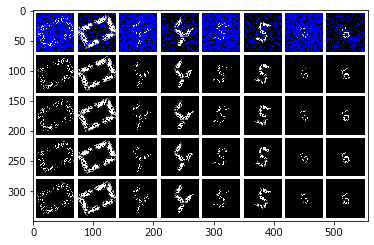

In [156]:
compose = tf.Compose([
    tf.ToPILImage(),
    tf.Lambda(lambda x: tf.functional.affine(x, 0, (0, 0), 0.8, 0)),
    tf.ToTensor()
])

test_tf = tf.Compose([
    tf.Pad(16),
    tf.Lambda(lambda x: tf.functional.affine(x, 0, (0, 0), 2.0, 0)),
    tf.ToTensor()
])
transforms = tf.Compose([
            tf.Pad(16),
            tf.RandomAffine(degrees=90, scale=(0.6, 0.9)),
            tf.ToTensor()
        ])
testset = ClockDigit("~/data/clockdigits", download=True, transform=test_tf)
idx = torch.randperm(10)
imgs = []
for i in range(5):
    img = testset[idx[i]][0]
    imgs.append(img)
training = torch.stack(imgs)

testset = ClockDigit("~/data/clockdigits", download=True, transform=transforms)
imgs = []
for i in range(5):
    img = testset[idx[i+5]][0]
    imgs.append(img)
test_data = torch.stack(imgs)

In [160]:
save_image(make_grid(torch.cat([training, test_data], 0), nrow=5, pad_value=1), 'digits.pdf')

In [110]:
save_image(make_grid(torch.stack(imgs), pad_value=1), 'digits.pdf')

In [116]:
training = torch.stack(imgs)

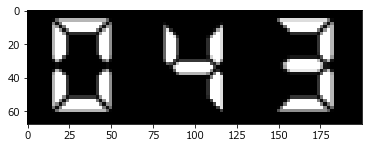

In [117]:
show(make_grid(training))

In [124]:
test_data = torch.stack(imgs)

In [133]:
save_image(make_grid(torch.cat([training, test_data], 0), nrow=3, pad_value=1), 'digits.pdf')

In [145]:
masks = []
for i in range(4):
    ctx_mask25 = torch.empty(1, 64, 64).bernoulli_(0.25)
    ctx_mask75 = torch.empty(1, 64, 64).bernoulli_(0.75)
    masks += [ctx_mask25, ctx_mask75]

imgs = []
idx = torch.randperm(10)
for i in range(4):
    test_tf = tf.Compose([
        tf.Pad(16),
        tf.Lambda(lambda x: tf.functional.affine(x, 5, (0, 0), 2.0 - i * 0.5 + 0.1, 0)),
        tf.RandomAffine(degrees=90),
        tf.ToTensor()
    ])
    testset = ClockDigit("~/data/clockdigits", download=True, transform=test_tf)
    img = testset[idx[i]][0]
    imgs += [img, img]
# ctx_signal = (ctx_mask * img).permute(1, 2, 0).reshape(1, -1, 1)
# ctx_coords = torch.linspace(-32, 32, 64).float()
# ctx_coords = torch.stack(torch.meshgrid([ctx_coords, ctx_coords]), -1).reshape(1, -1, 2)
# ctx_density = ctx_mask.reshape(1, -1, 1)
# ctx_mask = torch.ones(1, 4096).bool()

ctx_mask = torch.stack(masks, 0)
ctx_img = torch.stack(imgs, 0)

In [148]:
outputs = []
for m in range(4):
    tmp = []
    for cm, cx in zip(ctx_mask, ctx_img):
        tmp.append(cm.unsqueeze(0))
    outputs.append(tmp)
    

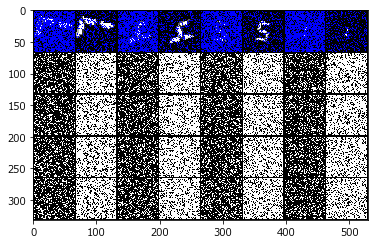

In [155]:
show(make_grid(torch.cat([observed] + [torch.cat(o, 0).repeat(1, 3, 1, 1) for o in outputs], 0)))